# OCRA Demo
This notebook shows how to train or test the model. Also included are methods to display model outputs and attention mechanimsms 

In [1]:
# load required libraries & modules
import os
from tqdm.notebook import tqdm
import pprint
import time

import torch

from utils import *
from ocra import *
from loaddata import *

import warnings
# warnings.filterwarnings('ignore')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# for training

In [2]:
############################################
# create model instance using param file 
############################################

# load training args using param file 
# it can be 1) multimnist_params.txt or 2) multimnist_cluttered_params.txt
# params_filename = 'multimnist_cluttered_params.txt'
params_filename = 'svrt_task1_params.txt'
args = parse_params(params_filename)
    
if args.restore_file: # if you want to pick up from save-point, reload param files
    params_filename = os.path.dirname(args.restore_file) + '/params.txt'
    assert os.path.isfile(params_filename), "No param flie exists"
    removelist = ['device'] # remove the arguments that caanot be translated into literal
    args = parse_params_wremove(params_filename, removelist) 

pprint.pprint(args.__dict__, sort_dicts=False)


# if recon_model=False, makes loss from reconstruciton 0
if not args.recon_model:
    args.lam_recon=0
    
# setup output directory where log folder should be created 
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

# set device
args.device = torch.device('cuda:{}'.format(args.cuda) if torch.cuda.is_available() and args.cuda is not None else 'cpu')

# set up model, optimizer, and hooks for monitoring
model = OCRA(args).to(args.device) 
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.999))
# if args.record_attn_hooks:
#     record_forward_backward_attn_hooks(model)

# print model info
count_parameters(model)

{'task': 'svrt_task1',
 'num_classes': 4,
 'num_targets': 3,
 'image_dims': (1, 64, 64),
 'cat_dup': False,
 'n_epochs': 1000,
 'lr': 0.001,
 'train_batch_size': 128,
 'test_batch_size': 128,
 'cuda': 0,
 'data_dir': './data/',
 'output_dir': './results/svrt_task1/',
 'restore_file': None,
 'save_checkpoint': True,
 'record_gradnorm': False,
 'record_attn_hooks': False,
 'validate_after_howmany_epochs': 1,
 'best_val_acc': 0,
 'verbose': True,
 'use_read_attn': True,
 'read_size': 18,
 'use_write_attn': True,
 'write_size': 18,
 'use_backbone': 'conv_small',
 'conv1_nfilters': 32,
 'conv2_nfilters': 32,
 'time_steps': 10,
 'include_xhat': False,
 'lstm_size': 512,
 'decoder_encoder_feedback': True,
 'use_capsnet': True,
 'num_zcaps': 40,
 'dim_zcaps': 8,
 'routings': 3,
 'dim_objectcaps': 16,
 'backg_objcaps': 0,
 'mask_objectcaps': False,
 'class_cond_mask': False,
 'recon_model': True,
 'lam_recon': 30,
 'clip_c': True,
 'use_recon_mask': False}
+-------------------------------+-----

4698604

## training the model

In [3]:
###########################
# model training...
##########################

DO_TRAIN = True  # false if you want to skip this cell
if DO_TRAIN:
    # load dataloader 
    train_dataloader, val_dataloader = fetch_dataloader(args, args.train_batch_size, train=True, train_val_split='train-val')

    # set writer for tensorboard
    writer, current_log_path = set_writer(log_path = args.output_dir if args.restore_file is None else os.path.dirname(args.restore_file),
                        comment = '', 
                        restore = args.restore_file is not None) 

    args.log_dir = current_log_path

    # save used param info to writer and logging directory
    writer.add_text('Params', pprint.pformat(args.__dict__))
    with open(os.path.join(args.log_dir, 'params.txt'), 'w') as f:
        pprint.pprint(args.__dict__, f)

    # start training
    print('Start training with args set above...')
    train_and_evaluate(model, train_dataloader, val_dataloader, loss_fn, optimizer, writer, args)

    writer.close()

Start training with args set above...


epoch 1 of 1000: 100%|█████████████████████████████████████████████| 422/422 [01:10<00:00,  6.00it/s, batch_loss=1.281]


==> Epoch 01: train_loss=0.01085, val_loss=0.00824, val_L_recon=0.00654, val_L_margin=0.00170, val_acc_partial=0.5041,  val_acc_exact=0.5041
the model with best val_acc (0.5041) was saved to disk


epoch 2 of 1000: 100%|█████████████████████████████████████████████| 422/422 [01:10<00:00,  5.95it/s, batch_loss=1.059]


==> Epoch 02: train_loss=0.00870, val_loss=0.00650, val_L_recon=0.00483, val_L_margin=0.00167, val_acc_partial=0.5323,  val_acc_exact=0.5323
the model with best val_acc (0.5323) was saved to disk


epoch 3 of 1000: 100%|█████████████████████████████████████████████| 422/422 [01:16<00:00,  5.53it/s, batch_loss=0.962]


==> Epoch 03: train_loss=0.00769, val_loss=0.00599, val_L_recon=0.00439, val_L_margin=0.00160, val_acc_partial=0.5949,  val_acc_exact=0.5949
the model with best val_acc (0.5949) was saved to disk


epoch 4 of 1000: 100%|█████████████████████████████████████████████| 422/422 [01:16<00:00,  5.52it/s, batch_loss=0.809]


==> Epoch 04: train_loss=0.00700, val_loss=0.00512, val_L_recon=0.00363, val_L_margin=0.00149, val_acc_partial=0.6335,  val_acc_exact=0.6335
the model with best val_acc (0.6335) was saved to disk


epoch 5 of 1000: 100%|█████████████████████████████████████████████| 422/422 [01:17<00:00,  5.46it/s, batch_loss=0.720]


==> Epoch 05: train_loss=0.00640, val_loss=0.00474, val_L_recon=0.00333, val_L_margin=0.00141, val_acc_partial=0.6652,  val_acc_exact=0.6652
the model with best val_acc (0.6652) was saved to disk


epoch 6 of 1000: 100%|█████████████████████████████████████████████| 422/422 [01:18<00:00,  5.35it/s, batch_loss=0.708]


==> Epoch 06: train_loss=0.00600, val_loss=0.00446, val_L_recon=0.00315, val_L_margin=0.00131, val_acc_partial=0.7043,  val_acc_exact=0.7043
the model with best val_acc (0.7043) was saved to disk


epoch 7 of 1000: 100%|█████████████████████████████████████████████| 422/422 [01:22<00:00,  5.12it/s, batch_loss=0.602]


==> Epoch 07: train_loss=0.00547, val_loss=0.00394, val_L_recon=0.00282, val_L_margin=0.00113, val_acc_partial=0.7736,  val_acc_exact=0.7736
the model with best val_acc (0.7736) was saved to disk


epoch 8 of 1000: 100%|█████████████████████████████████████████████| 422/422 [01:24<00:00,  5.02it/s, batch_loss=0.499]


==> Epoch 08: train_loss=0.00470, val_loss=0.00351, val_L_recon=0.00255, val_L_margin=0.00095, val_acc_partial=0.8155,  val_acc_exact=0.8155
the model with best val_acc (0.8155) was saved to disk


epoch 9 of 1000: 100%|█████████████████████████████████████████████| 422/422 [01:24<00:00,  5.00it/s, batch_loss=0.444]


==> Epoch 09: train_loss=0.00401, val_loss=0.00324, val_L_recon=0.00256, val_L_margin=0.00068, val_acc_partial=0.8787,  val_acc_exact=0.8787
the model with best val_acc (0.8787) was saved to disk


epoch 10 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:24<00:00,  4.98it/s, batch_loss=0.361]


==> Epoch 10: train_loss=0.00359, val_loss=0.00299, val_L_recon=0.00241, val_L_margin=0.00058, val_acc_partial=0.8960,  val_acc_exact=0.8960
the model with best val_acc (0.8960) was saved to disk


epoch 11 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:25<00:00,  4.93it/s, batch_loss=0.474]


==> Epoch 11: train_loss=0.00341, val_loss=0.00313, val_L_recon=0.00249, val_L_margin=0.00065, val_acc_partial=0.8874,  val_acc_exact=0.8874


epoch 12 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:26<00:00,  4.91it/s, batch_loss=0.351]


==> Epoch 12: train_loss=0.00325, val_loss=0.00251, val_L_recon=0.00206, val_L_margin=0.00046, val_acc_partial=0.9230,  val_acc_exact=0.9230
the model with best val_acc (0.9230) was saved to disk


epoch 13 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:31<00:00,  4.59it/s, batch_loss=0.363]


==> Epoch 13: train_loss=0.00288, val_loss=0.00240, val_L_recon=0.00201, val_L_margin=0.00040, val_acc_partial=0.9315,  val_acc_exact=0.9315
the model with best val_acc (0.9315) was saved to disk


epoch 14 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.43it/s, batch_loss=0.262]


==> Epoch 14: train_loss=0.00278, val_loss=0.00218, val_L_recon=0.00183, val_L_margin=0.00035, val_acc_partial=0.9409,  val_acc_exact=0.9409
the model with best val_acc (0.9409) was saved to disk


epoch 15 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.41it/s, batch_loss=0.309]


==> Epoch 15: train_loss=0.00260, val_loss=0.00230, val_L_recon=0.00191, val_L_margin=0.00039, val_acc_partial=0.9332,  val_acc_exact=0.9332


epoch 16 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:31<00:00,  4.59it/s, batch_loss=0.274]


==> Epoch 16: train_loss=0.00265, val_loss=0.00218, val_L_recon=0.00184, val_L_margin=0.00034, val_acc_partial=0.9477,  val_acc_exact=0.9477
the model with best val_acc (0.9477) was saved to disk


epoch 17 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:30<00:00,  4.67it/s, batch_loss=0.310]


==> Epoch 17: train_loss=0.00273, val_loss=0.00217, val_L_recon=0.00184, val_L_margin=0.00033, val_acc_partial=0.9456,  val_acc_exact=0.9456


epoch 18 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:31<00:00,  4.64it/s, batch_loss=0.229]


==> Epoch 18: train_loss=0.00237, val_loss=0.00194, val_L_recon=0.00168, val_L_margin=0.00026, val_acc_partial=0.9572,  val_acc_exact=0.9572
the model with best val_acc (0.9572) was saved to disk


epoch 19 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.57it/s, batch_loss=0.252]


==> Epoch 19: train_loss=0.00277, val_loss=0.00203, val_L_recon=0.00177, val_L_margin=0.00025, val_acc_partial=0.9588,  val_acc_exact=0.9588
the model with best val_acc (0.9588) was saved to disk


epoch 20 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.58it/s, batch_loss=0.251]


==> Epoch 20: train_loss=0.00216, val_loss=0.00222, val_L_recon=0.00198, val_L_margin=0.00024, val_acc_partial=0.9606,  val_acc_exact=0.9606
the model with best val_acc (0.9606) was saved to disk


epoch 21 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:30<00:00,  4.65it/s, batch_loss=0.245]


==> Epoch 21: train_loss=0.00209, val_loss=0.00177, val_L_recon=0.00155, val_L_margin=0.00022, val_acc_partial=0.9621,  val_acc_exact=0.9621
the model with best val_acc (0.9621) was saved to disk


epoch 22 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.59it/s, batch_loss=0.231]


==> Epoch 22: train_loss=0.00214, val_loss=0.00198, val_L_recon=0.00176, val_L_margin=0.00021, val_acc_partial=0.9663,  val_acc_exact=0.9663
the model with best val_acc (0.9663) was saved to disk


epoch 23 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:31<00:00,  4.61it/s, batch_loss=0.240]


==> Epoch 23: train_loss=0.00205, val_loss=0.00178, val_L_recon=0.00155, val_L_margin=0.00023, val_acc_partial=0.9621,  val_acc_exact=0.9621


epoch 24 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:34<00:00,  4.46it/s, batch_loss=0.275]


==> Epoch 24: train_loss=0.00212, val_loss=0.00224, val_L_recon=0.00190, val_L_margin=0.00034, val_acc_partial=0.9399,  val_acc_exact=0.9399


epoch 25 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.42it/s, batch_loss=0.371]


==> Epoch 25: train_loss=0.00265, val_loss=0.00253, val_L_recon=0.00211, val_L_margin=0.00042, val_acc_partial=0.9282,  val_acc_exact=0.9282


epoch 26 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:33<00:00,  4.53it/s, batch_loss=0.241]


==> Epoch 26: train_loss=0.00210, val_loss=0.00179, val_L_recon=0.00157, val_L_margin=0.00022, val_acc_partial=0.9631,  val_acc_exact=0.9631


epoch 27 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.56it/s, batch_loss=0.255]


==> Epoch 27: train_loss=0.00220, val_loss=0.00190, val_L_recon=0.00171, val_L_margin=0.00019, val_acc_partial=0.9717,  val_acc_exact=0.9717
the model with best val_acc (0.9717) was saved to disk


epoch 28 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:37<00:00,  4.32it/s, batch_loss=0.211]


==> Epoch 28: train_loss=0.00182, val_loss=0.00174, val_L_recon=0.00157, val_L_margin=0.00018, val_acc_partial=0.9709,  val_acc_exact=0.9709


epoch 29 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.55it/s, batch_loss=0.254]


==> Epoch 29: train_loss=0.00188, val_loss=0.00219, val_L_recon=0.00197, val_L_margin=0.00022, val_acc_partial=0.9632,  val_acc_exact=0.9632


epoch 30 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:33<00:00,  4.53it/s, batch_loss=0.273]


==> Epoch 30: train_loss=0.00180, val_loss=0.00209, val_L_recon=0.00180, val_L_margin=0.00029, val_acc_partial=0.9573,  val_acc_exact=0.9573


epoch 31 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:34<00:00,  4.48it/s, batch_loss=0.193]


==> Epoch 31: train_loss=0.00222, val_loss=0.00168, val_L_recon=0.00149, val_L_margin=0.00019, val_acc_partial=0.9698,  val_acc_exact=0.9698


epoch 32 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:33<00:00,  4.53it/s, batch_loss=0.263]


==> Epoch 32: train_loss=0.00179, val_loss=0.00188, val_L_recon=0.00164, val_L_margin=0.00024, val_acc_partial=0.9606,  val_acc_exact=0.9606


epoch 33 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:34<00:00,  4.48it/s, batch_loss=0.298]


==> Epoch 33: train_loss=0.00212, val_loss=0.00200, val_L_recon=0.00169, val_L_margin=0.00030, val_acc_partial=0.9523,  val_acc_exact=0.9523


epoch 34 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:34<00:00,  4.48it/s, batch_loss=0.217]


==> Epoch 34: train_loss=0.00176, val_loss=0.00161, val_L_recon=0.00142, val_L_margin=0.00019, val_acc_partial=0.9682,  val_acc_exact=0.9682


epoch 35 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:34<00:00,  4.47it/s, batch_loss=0.227]


==> Epoch 35: train_loss=0.00177, val_loss=0.00187, val_L_recon=0.00161, val_L_margin=0.00026, val_acc_partial=0.9596,  val_acc_exact=0.9596


epoch 36 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.55it/s, batch_loss=0.215]


==> Epoch 36: train_loss=0.00213, val_loss=0.00171, val_L_recon=0.00149, val_L_margin=0.00022, val_acc_partial=0.9636,  val_acc_exact=0.9636


epoch 37 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:33<00:00,  4.53it/s, batch_loss=0.185]


==> Epoch 37: train_loss=0.00179, val_loss=0.00147, val_L_recon=0.00133, val_L_margin=0.00014, val_acc_partial=0.9786,  val_acc_exact=0.9786
the model with best val_acc (0.9786) was saved to disk


epoch 38 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:31<00:00,  4.60it/s, batch_loss=0.167]


==> Epoch 38: train_loss=0.00188, val_loss=0.00142, val_L_recon=0.00128, val_L_margin=0.00014, val_acc_partial=0.9773,  val_acc_exact=0.9773


epoch 39 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.54it/s, batch_loss=0.161]


==> Epoch 39: train_loss=0.00161, val_loss=0.00130, val_L_recon=0.00117, val_L_margin=0.00012, val_acc_partial=0.9799,  val_acc_exact=0.9799
the model with best val_acc (0.9799) was saved to disk


epoch 40 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.58it/s, batch_loss=0.203]


==> Epoch 40: train_loss=0.00161, val_loss=0.00166, val_L_recon=0.00149, val_L_margin=0.00017, val_acc_partial=0.9724,  val_acc_exact=0.9724


epoch 41 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:37<00:00,  4.31it/s, batch_loss=0.267]


==> Epoch 41: train_loss=0.00187, val_loss=0.00200, val_L_recon=0.00180, val_L_margin=0.00020, val_acc_partial=0.9690,  val_acc_exact=0.9690


epoch 42 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:34<00:00,  4.47it/s, batch_loss=0.198]


==> Epoch 42: train_loss=0.00163, val_loss=0.00136, val_L_recon=0.00124, val_L_margin=0.00012, val_acc_partial=0.9813,  val_acc_exact=0.9813
the model with best val_acc (0.9813) was saved to disk


epoch 43 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.57it/s, batch_loss=0.168]


==> Epoch 43: train_loss=0.00168, val_loss=0.00141, val_L_recon=0.00128, val_L_margin=0.00012, val_acc_partial=0.9813,  val_acc_exact=0.9813


epoch 44 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.44it/s, batch_loss=0.190]


==> Epoch 44: train_loss=0.00175, val_loss=0.00168, val_L_recon=0.00145, val_L_margin=0.00022, val_acc_partial=0.9660,  val_acc_exact=0.9660


epoch 45 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:33<00:00,  4.49it/s, batch_loss=0.181]


==> Epoch 45: train_loss=0.00175, val_loss=0.00149, val_L_recon=0.00133, val_L_margin=0.00017, val_acc_partial=0.9757,  val_acc_exact=0.9757


epoch 46 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.55it/s, batch_loss=0.166]


==> Epoch 46: train_loss=0.00148, val_loss=0.00139, val_L_recon=0.00127, val_L_margin=0.00011, val_acc_partial=0.9834,  val_acc_exact=0.9834
the model with best val_acc (0.9834) was saved to disk


epoch 47 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:36<00:00,  4.37it/s, batch_loss=0.144]


==> Epoch 47: train_loss=0.00140, val_loss=0.00126, val_L_recon=0.00115, val_L_margin=0.00011, val_acc_partial=0.9826,  val_acc_exact=0.9826


epoch 48 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:36<00:00,  4.39it/s, batch_loss=0.162]


==> Epoch 48: train_loss=0.00143, val_loss=0.00134, val_L_recon=0.00123, val_L_margin=0.00012, val_acc_partial=0.9817,  val_acc_exact=0.9817


epoch 49 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:33<00:00,  4.51it/s, batch_loss=0.163]


==> Epoch 49: train_loss=0.00179, val_loss=0.00126, val_L_recon=0.00114, val_L_margin=0.00012, val_acc_partial=0.9832,  val_acc_exact=0.9832


epoch 50 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.57it/s, batch_loss=0.169]


==> Epoch 50: train_loss=0.00147, val_loss=0.00144, val_L_recon=0.00131, val_L_margin=0.00013, val_acc_partial=0.9806,  val_acc_exact=0.9806


epoch 51 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.55it/s, batch_loss=0.202]


==> Epoch 51: train_loss=0.00154, val_loss=0.00150, val_L_recon=0.00131, val_L_margin=0.00019, val_acc_partial=0.9673,  val_acc_exact=0.9673


epoch 52 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:38<00:00,  4.26it/s, batch_loss=0.148]


==> Epoch 52: train_loss=0.00148, val_loss=0.00129, val_L_recon=0.00118, val_L_margin=0.00012, val_acc_partial=0.9823,  val_acc_exact=0.9823


epoch 53 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:38<00:00,  4.30it/s, batch_loss=0.153]


==> Epoch 53: train_loss=0.00146, val_loss=0.00128, val_L_recon=0.00117, val_L_margin=0.00012, val_acc_partial=0.9814,  val_acc_exact=0.9814


epoch 54 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.57it/s, batch_loss=0.160]


==> Epoch 54: train_loss=0.00171, val_loss=0.00142, val_L_recon=0.00130, val_L_margin=0.00012, val_acc_partial=0.9811,  val_acc_exact=0.9811


epoch 55 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:33<00:00,  4.51it/s, batch_loss=0.211]


==> Epoch 55: train_loss=0.00138, val_loss=0.00153, val_L_recon=0.00134, val_L_margin=0.00019, val_acc_partial=0.9744,  val_acc_exact=0.9744


epoch 56 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:33<00:00,  4.49it/s, batch_loss=0.217]


==> Epoch 56: train_loss=0.00141, val_loss=0.00149, val_L_recon=0.00137, val_L_margin=0.00012, val_acc_partial=0.9800,  val_acc_exact=0.9800


epoch 57 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:36<00:00,  4.39it/s, batch_loss=0.168]


==> Epoch 57: train_loss=0.00135, val_loss=0.00143, val_L_recon=0.00128, val_L_margin=0.00015, val_acc_partial=0.9767,  val_acc_exact=0.9767


epoch 58 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.42it/s, batch_loss=0.161]


==> Epoch 58: train_loss=0.00133, val_loss=0.00139, val_L_recon=0.00126, val_L_margin=0.00013, val_acc_partial=0.9815,  val_acc_exact=0.9815


epoch 59 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:39<00:00,  4.25it/s, batch_loss=0.134]


==> Epoch 59: train_loss=0.00139, val_loss=0.00118, val_L_recon=0.00108, val_L_margin=0.00010, val_acc_partial=0.9849,  val_acc_exact=0.9849
the model with best val_acc (0.9849) was saved to disk


epoch 60 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:32<00:00,  4.57it/s, batch_loss=0.134]


==> Epoch 60: train_loss=0.00163, val_loss=0.00124, val_L_recon=0.00114, val_L_margin=0.00010, val_acc_partial=0.9855,  val_acc_exact=0.9855
the model with best val_acc (0.9855) was saved to disk


epoch 61 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:36<00:00,  4.38it/s, batch_loss=0.165]


==> Epoch 61: train_loss=0.00140, val_loss=0.00138, val_L_recon=0.00120, val_L_margin=0.00018, val_acc_partial=0.9699,  val_acc_exact=0.9699


epoch 62 of 1000: 100%|████████████████████████████████████████████| 422/422 [02:04<00:00,  3.39it/s, batch_loss=0.147]


==> Epoch 62: train_loss=0.00138, val_loss=0.00108, val_L_recon=0.00100, val_L_margin=0.00009, val_acc_partial=0.9878,  val_acc_exact=0.9878
the model with best val_acc (0.9878) was saved to disk


epoch 63 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:40<00:00,  4.21it/s, batch_loss=0.185]


==> Epoch 63: train_loss=0.00125, val_loss=0.00137, val_L_recon=0.00124, val_L_margin=0.00014, val_acc_partial=0.9794,  val_acc_exact=0.9794


epoch 64 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.40it/s, batch_loss=0.183]


==> Epoch 64: train_loss=0.00142, val_loss=0.00126, val_L_recon=0.00110, val_L_margin=0.00015, val_acc_partial=0.9768,  val_acc_exact=0.9768


epoch 65 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:36<00:00,  4.37it/s, batch_loss=0.283]


==> Epoch 65: train_loss=0.00129, val_loss=0.00248, val_L_recon=0.00202, val_L_margin=0.00046, val_acc_partial=0.9297,  val_acc_exact=0.9297


epoch 66 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:36<00:00,  4.35it/s, batch_loss=0.280]


==> Epoch 66: train_loss=0.00212, val_loss=0.00179, val_L_recon=0.00150, val_L_margin=0.00029, val_acc_partial=0.9481,  val_acc_exact=0.9481


epoch 67 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:39<00:00,  4.23it/s, batch_loss=0.157]


==> Epoch 67: train_loss=0.00174, val_loss=0.00143, val_L_recon=0.00126, val_L_margin=0.00016, val_acc_partial=0.9776,  val_acc_exact=0.9776


epoch 68 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:37<00:00,  4.34it/s, batch_loss=0.157]


==> Epoch 68: train_loss=0.00141, val_loss=0.00127, val_L_recon=0.00114, val_L_margin=0.00013, val_acc_partial=0.9794,  val_acc_exact=0.9794


epoch 69 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.42it/s, batch_loss=0.144]


==> Epoch 69: train_loss=0.00150, val_loss=0.00112, val_L_recon=0.00104, val_L_margin=0.00008, val_acc_partial=0.9890,  val_acc_exact=0.9890
the model with best val_acc (0.9890) was saved to disk


epoch 70 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:37<00:00,  4.34it/s, batch_loss=0.222]


==> Epoch 70: train_loss=0.00125, val_loss=0.00179, val_L_recon=0.00151, val_L_margin=0.00028, val_acc_partial=0.9508,  val_acc_exact=0.9508


epoch 71 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:36<00:00,  4.37it/s, batch_loss=0.125]


==> Epoch 71: train_loss=0.00119, val_loss=0.00112, val_L_recon=0.00099, val_L_margin=0.00013, val_acc_partial=0.9791,  val_acc_exact=0.9791


epoch 72 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:33<00:00,  4.50it/s, batch_loss=0.345]


==> Epoch 72: train_loss=0.00129, val_loss=0.00264, val_L_recon=0.00207, val_L_margin=0.00056, val_acc_partial=0.8954,  val_acc_exact=0.8954


epoch 73 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:34<00:00,  4.47it/s, batch_loss=0.186]


==> Epoch 73: train_loss=0.00207, val_loss=0.00143, val_L_recon=0.00129, val_L_margin=0.00014, val_acc_partial=0.9813,  val_acc_exact=0.9813


epoch 74 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.41it/s, batch_loss=0.195]


==> Epoch 74: train_loss=0.00147, val_loss=0.00148, val_L_recon=0.00125, val_L_margin=0.00023, val_acc_partial=0.9729,  val_acc_exact=0.9729


epoch 75 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:36<00:00,  4.38it/s, batch_loss=0.117]


==> Epoch 75: train_loss=0.00130, val_loss=0.00125, val_L_recon=0.00112, val_L_margin=0.00013, val_acc_partial=0.9786,  val_acc_exact=0.9786


epoch 76 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.44it/s, batch_loss=0.177]


==> Epoch 76: train_loss=0.00140, val_loss=0.00137, val_L_recon=0.00122, val_L_margin=0.00015, val_acc_partial=0.9774,  val_acc_exact=0.9774


epoch 77 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.44it/s, batch_loss=0.147]


==> Epoch 77: train_loss=0.00119, val_loss=0.00126, val_L_recon=0.00114, val_L_margin=0.00012, val_acc_partial=0.9816,  val_acc_exact=0.9816


epoch 78 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:37<00:00,  4.32it/s, batch_loss=0.125]


==> Epoch 78: train_loss=0.00137, val_loss=0.00124, val_L_recon=0.00114, val_L_margin=0.00010, val_acc_partial=0.9863,  val_acc_exact=0.9863


epoch 79 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:36<00:00,  4.38it/s, batch_loss=0.126]


==> Epoch 79: train_loss=0.00137, val_loss=0.00118, val_L_recon=0.00108, val_L_margin=0.00010, val_acc_partial=0.9869,  val_acc_exact=0.9869


epoch 80 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.44it/s, batch_loss=0.112]


==> Epoch 80: train_loss=0.00125, val_loss=0.00105, val_L_recon=0.00095, val_L_margin=0.00010, val_acc_partial=0.9845,  val_acc_exact=0.9845


epoch 81 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:37<00:00,  4.34it/s, batch_loss=0.113]


==> Epoch 81: train_loss=0.00112, val_loss=0.00101, val_L_recon=0.00093, val_L_margin=0.00008, val_acc_partial=0.9877,  val_acc_exact=0.9877


epoch 82 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:39<00:00,  4.25it/s, batch_loss=0.153]


==> Epoch 82: train_loss=0.00121, val_loss=0.00115, val_L_recon=0.00103, val_L_margin=0.00012, val_acc_partial=0.9802,  val_acc_exact=0.9802


epoch 83 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:39<00:00,  4.24it/s, batch_loss=0.175]


==> Epoch 83: train_loss=0.00131, val_loss=0.00129, val_L_recon=0.00110, val_L_margin=0.00020, val_acc_partial=0.9677,  val_acc_exact=0.9677


epoch 84 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:39<00:00,  4.25it/s, batch_loss=0.133]


==> Epoch 84: train_loss=0.00140, val_loss=0.00104, val_L_recon=0.00095, val_L_margin=0.00009, val_acc_partial=0.9856,  val_acc_exact=0.9856


epoch 85 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:37<00:00,  4.34it/s, batch_loss=0.139]


==> Epoch 85: train_loss=0.00134, val_loss=0.00127, val_L_recon=0.00115, val_L_margin=0.00013, val_acc_partial=0.9804,  val_acc_exact=0.9804


epoch 86 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.42it/s, batch_loss=0.260]


==> Epoch 86: train_loss=0.00118, val_loss=0.00172, val_L_recon=0.00147, val_L_margin=0.00026, val_acc_partial=0.9602,  val_acc_exact=0.9602


epoch 87 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:34<00:00,  4.48it/s, batch_loss=1.142]


==> Epoch 87: train_loss=0.00351, val_loss=0.00696, val_L_recon=0.00528, val_L_margin=0.00168, val_acc_partial=0.5452,  val_acc_exact=0.5452


epoch 88 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:36<00:00,  4.38it/s, batch_loss=0.264]


==> Epoch 88: train_loss=0.00488, val_loss=0.00203, val_L_recon=0.00172, val_L_margin=0.00031, val_acc_partial=0.9619,  val_acc_exact=0.9619


epoch 89 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:36<00:00,  4.40it/s, batch_loss=0.179]


==> Epoch 89: train_loss=0.00186, val_loss=0.00164, val_L_recon=0.00146, val_L_margin=0.00019, val_acc_partial=0.9744,  val_acc_exact=0.9744


epoch 90 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:38<00:00,  4.30it/s, batch_loss=0.174]


==> Epoch 90: train_loss=0.00149, val_loss=0.00154, val_L_recon=0.00132, val_L_margin=0.00022, val_acc_partial=0.9642,  val_acc_exact=0.9642


epoch 91 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:41<00:00,  4.16it/s, batch_loss=0.182]


==> Epoch 91: train_loss=0.00136, val_loss=0.00136, val_L_recon=0.00120, val_L_margin=0.00015, val_acc_partial=0.9788,  val_acc_exact=0.9788


epoch 92 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.42it/s, batch_loss=0.219]


==> Epoch 92: train_loss=0.00132, val_loss=0.00173, val_L_recon=0.00149, val_L_margin=0.00024, val_acc_partial=0.9617,  val_acc_exact=0.9617


epoch 93 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:36<00:00,  4.39it/s, batch_loss=0.289]


==> Epoch 93: train_loss=0.00160, val_loss=0.00203, val_L_recon=0.00169, val_L_margin=0.00034, val_acc_partial=0.9494,  val_acc_exact=0.9494


epoch 94 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:38<00:00,  4.28it/s, batch_loss=0.243]


==> Epoch 94: train_loss=0.00148, val_loss=0.00158, val_L_recon=0.00135, val_L_margin=0.00022, val_acc_partial=0.9640,  val_acc_exact=0.9640


epoch 95 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:37<00:00,  4.32it/s, batch_loss=0.135]


==> Epoch 95: train_loss=0.00129, val_loss=0.00100, val_L_recon=0.00092, val_L_margin=0.00009, val_acc_partial=0.9875,  val_acc_exact=0.9875


epoch 96 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:34<00:00,  4.47it/s, batch_loss=0.174]


==> Epoch 96: train_loss=0.00115, val_loss=0.00126, val_L_recon=0.00113, val_L_margin=0.00013, val_acc_partial=0.9789,  val_acc_exact=0.9789


epoch 97 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.44it/s, batch_loss=0.147]


==> Epoch 97: train_loss=0.00126, val_loss=0.00132, val_L_recon=0.00122, val_L_margin=0.00010, val_acc_partial=0.9836,  val_acc_exact=0.9836


epoch 98 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.41it/s, batch_loss=0.115]


==> Epoch 98: train_loss=0.00127, val_loss=0.00104, val_L_recon=0.00096, val_L_margin=0.00008, val_acc_partial=0.9880,  val_acc_exact=0.9880


epoch 99 of 1000: 100%|████████████████████████████████████████████| 422/422 [01:35<00:00,  4.42it/s, batch_loss=0.126]


==> Epoch 99: train_loss=0.00119, val_loss=0.00110, val_L_recon=0.00100, val_L_margin=0.00010, val_acc_partial=0.9860,  val_acc_exact=0.9860


epoch 100 of 1000: 100%|███████████████████████████████████████████| 422/422 [01:39<00:00,  4.23it/s, batch_loss=0.139]


==> Epoch 100: train_loss=0.00113, val_loss=0.00128, val_L_recon=0.00109, val_L_margin=0.00018, val_acc_partial=0.9722,  val_acc_exact=0.9722


epoch 101 of 1000: 100%|███████████████████████████████████████████| 422/422 [01:39<00:00,  4.25it/s, batch_loss=0.193]


==> Epoch 101: train_loss=0.00127, val_loss=0.00152, val_L_recon=0.00129, val_L_margin=0.00023, val_acc_partial=0.9699,  val_acc_exact=0.9699


epoch 102 of 1000: 100%|███████████████████████████████████████████| 422/422 [01:37<00:00,  4.32it/s, batch_loss=0.151]


==> Epoch 102: train_loss=0.00136, val_loss=0.00126, val_L_recon=0.00109, val_L_margin=0.00016, val_acc_partial=0.9701,  val_acc_exact=0.9701


epoch 103 of 1000:   0%|▏                                            | 2/422 [00:00<02:34,  2.71it/s, batch_loss=0.167]


KeyboardInterrupt: 

## For Testing

In [ ]:
###########################
# model testing...
##########################

# testing parameters
DO_TEST = True # false if you want to skip this cell
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# give path for the model to load, or None if you want to continue with the current trained model
load_model_path = None #'./results/svrt_task1/....pt'


if DO_TEST:
    if load_model_path: # if path is given, load a saved model (make sure tha you loaded right model args)
        # load param file
        params_filename = os.path.dirname(load_model_path) + '/params.txt'
        assert os.path.isfile(params_filename), "No param flie exists"
        removelist = ['device'] # remove the arguments that caanot be translated into literal
        args = parse_params_wremove(params_filename, removelist) 
        #args.use_capsnet = use_capsnet
        args.device = device 
        pprint.pprint(args.__dict__, sort_dicts=False)
        
        # load model
        model = OCRA(args).to(args.device) 
        model.load_state_dict(torch.load(load_model_path))
        print('model loaded.')
        
        # get test results
        model.eval()
        test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
        test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact = test(model, test_dataloader, args)
        print("==> Epoch %02d: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
              % (args.n_epochs, test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

    else: # use the current trained model to get results
        model.eval()
        test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
        test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact = test(model, test_dataloader, args)
        print("==> Epoch %02d: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
              % (args.n_epochs, test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

##  Examining model outputs for a single test batch 

In [4]:
# Putting hooks to gather attention parameters

from functools import partial

read_mu_xs = []
read_mu_ys = []
def record_read_attn_params(self, in_tensor, out_tensor, bank_name):
    g_x, g_y, logvar, logdelta = out_tensor.cpu().split(split_size=1, dim=1) # loggamma
    g_x, g_y, delta, mu_x, mu_y, F_x, F_y = compute_filterbank_matrices(g_x, g_y, logvar, logdelta, args.image_dims[1]
                                                                                    , args.image_dims[2], args.read_size)
    read_mu_xs.append(mu_x)
    read_mu_ys.append(mu_y)
    
model.read_attention_linear.register_forward_hook(partial(record_read_attn_params, bank_name='read'))


write_mu_xs = []
write_mu_ys = []
def record_write_attn_params(self, in_tensor, out_tensor, bank_name):
    g_x, g_y, logvar, logdelta = out_tensor.cpu().split(split_size=1, dim=1) # loggamma
    g_x, g_y, delta, mu_x, mu_y, F_x, F_y = compute_filterbank_matrices(g_x, g_y, logvar, logdelta, args.image_dims[1]
                                                                                    , args.image_dims[2], args.write_size)
    write_mu_xs.append(mu_x)
    write_mu_ys.append(mu_y)

model.write_attention_linear.register_forward_hook(partial(record_write_attn_params, bank_name='write'))

# activation = []
# def get_activation(name):
#     def hook(model, input, output):
#         activation.append(output.detach())
#         print(output.detach().shape)
#     return hook

# model.bb_conv1.register_forward_hook(get_activation('bb_conv1'))

In [5]:
# test the model accuracy on a single batch and plot the images

%matplotlib inline 
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image, make_grid
to_img = ToPILImage()
from PIL import Image
import os.path
import glob
import numpy as np
import math
import copy 
from matplotlib.patches import Rectangle
from IPython.display import Image as IP_Image

test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
train_dataloader, val_dataloader = fetch_dataloader(args, args.train_batch_size, train=True, train_val_split='train-val')
x, y = next(iter(test_dataloader))
y = y.type(torch.int64)
    
top_k = args.num_targets

# if one target and y is not in one-hot format, convert it to one-hot encoding
if args.num_targets == 1:
    if len(y.shape) < 2: 
        y = y.type(torch.int64)
        y = torch.zeros(y.size(0), args.num_classes).scatter_(1, y.view(-1, 1), 1.) 

batch_loss, batch_L_recon, batch_L_margin, batch_correct_exact, batch_correct_partial, read_x_step, \
        c_each, y_pred, objcaps_len_step, readout_logits =  evaluate(model, x, y, loss_fn, args)

#args.test_batch_size = 128
read_x_step = torch.reshape(read_x_step, (args.test_batch_size,-1, 1, args.image_dims[1], args.image_dims[2]))
c_each = torch.reshape(c_each, (args.test_batch_size,-1, *args.image_dims))

test_loss = batch_loss / args.test_batch_size
test_L_recon = batch_L_recon / args.test_batch_size
test_L_margin = batch_L_margin / args.test_batch_size
test_acc_partial = batch_correct_partial / args.test_batch_size
test_acc_exact = batch_correct_exact / args.test_batch_size

# for visualization 
if args.task == 'mnist_ctrv':
    x = 1.0 - x

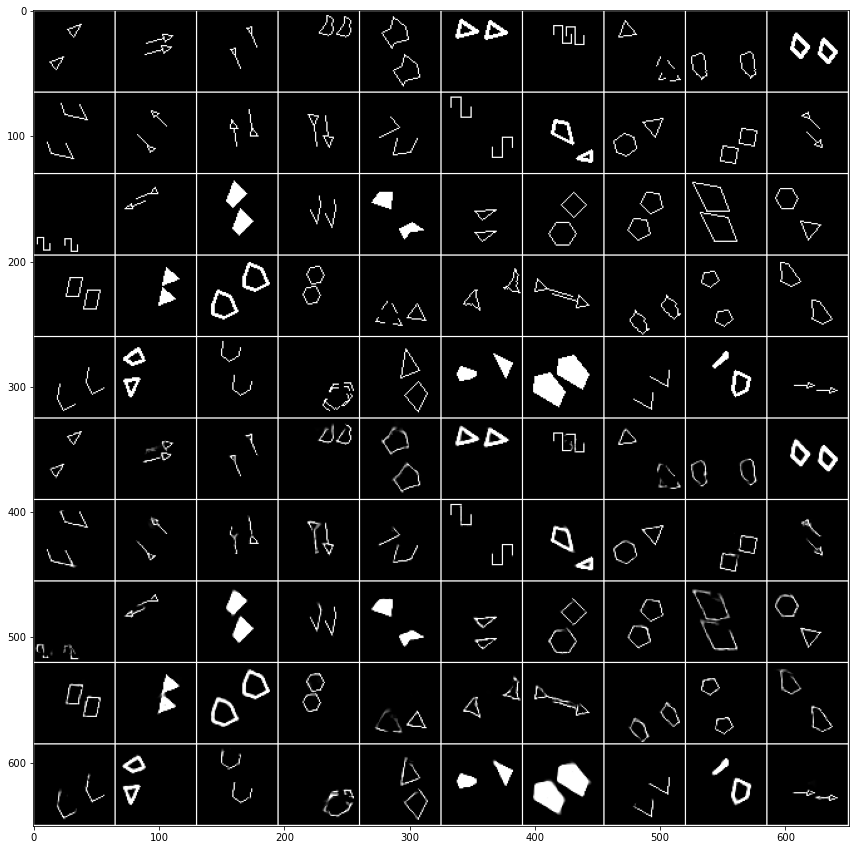

torch.Size([1280, 1, 64, 64])


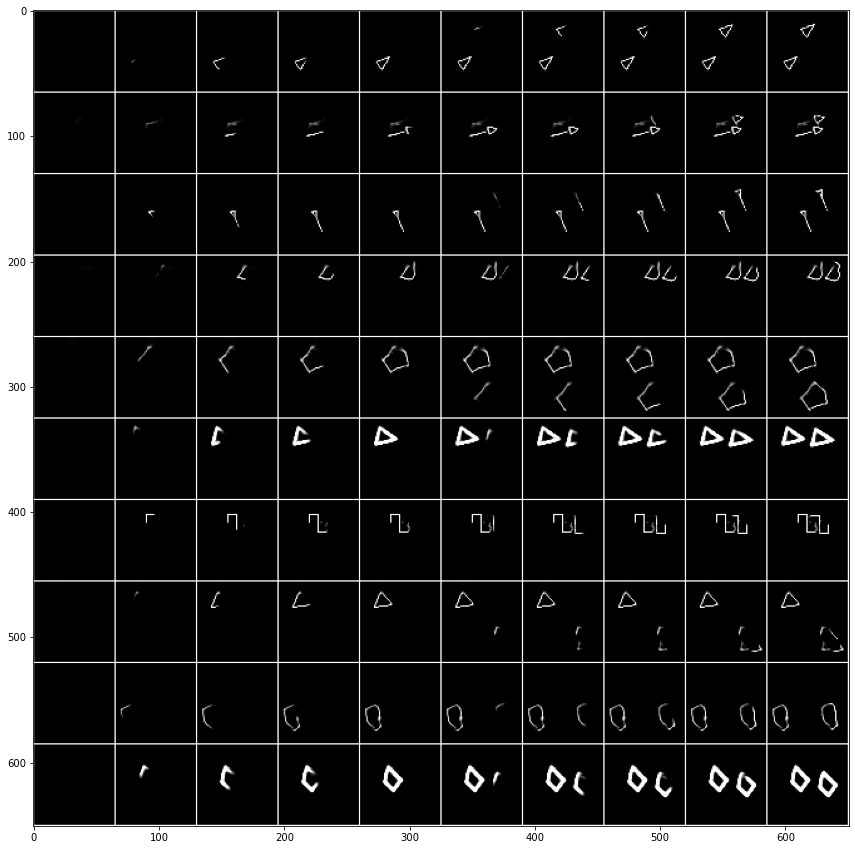

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

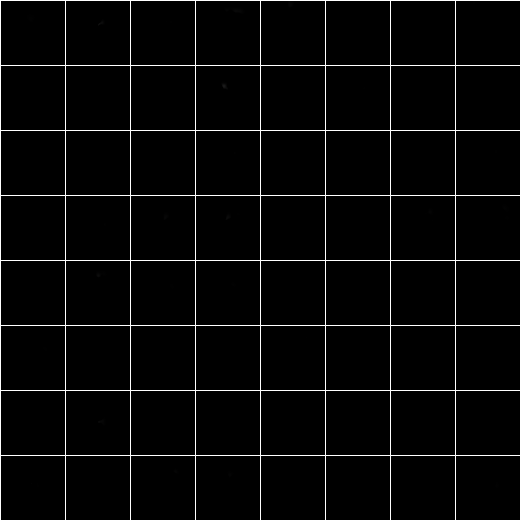

In [6]:
# plot and save image outputs

img_g = torch.cat((x[:50].to(args.device),torch.sum(c_each,dim=1)[:50]))
img_g = make_grid(img_g, nrow=10, padding=1, normalize=False, pad_value=1)
save_name = 'image_grid_r{}_w{}_steps{}_t{}.png'.format(args.read_size, args.write_size, args.time_steps, args.num_targets)
save_image(img_g, os.path.join(args.output_dir, save_name))
img_g = Image.open(os.path.join(args.output_dir, save_name))
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
plt.imshow(img_g) #matplot imshow() WILL AUTO CHANGE ONE CHANNEL IMG TO COLOR ONE
plt.show()

# reconstructoin steps
c_cumu_step = []
for i in range(args.time_steps):
    c_cumu_step.append(torch.squeeze(torch.cumsum(c_each,dim=1).narrow(1,i,1)))
        
        
num_imgs = 10
images = torch.stack(c_cumu_step, dim=1).view(-1, *args.image_dims)  # reshape to (10*time_steps, 1, 28, 28)
print(images.shape)
images = make_grid(images[0:num_imgs*len(c_cumu_step)], nrow=len(c_cumu_step), padding=1, normalize=False, pad_value=1)
save_name = 'generated_sequences_r{}_w{}_steps{}_t{}.png'.format(args.read_size, args.write_size,args.time_steps,args.num_targets)
save_image(images, os.path.join(args.output_dir, save_name))
images = Image.open(os.path.join(args.output_dir, save_name))
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
plt.imshow(images) #matplot imshow() WILL AUTO CHANGE ONE CHANNEL IMG TO COLOR ONE
plt.show()

# make gif
num_imgs = 64
c_cumu_step_gif = copy.deepcopy(c_cumu_step)
for i in range(len(c_cumu_step)):
    # convert sequence of image tensors to 8x8 grid
    image = make_grid(c_cumu_step[i][:num_imgs].view(-1, *args.image_dims).clip(max=1).cpu(), \
                      nrow=int(math.sqrt(num_imgs)), padding=1, normalize=False, pad_value=1)
    # make into gif
    c_cumu_step_gif[i] = image.data.numpy().transpose(1,2,0)

import imageio
file_add = (os.path.join(args.output_dir, 'generated_{}_time_steps_t{}.gif'.format(args.time_steps, args.num_targets)))
imageio.mimsave(file_add, c_cumu_step_gif)

IP_Image(open(file_add,'rb').read(), width = 600, height = 600)

## Plotting attention windows for all timesteps 


****************************************************************************************************
trial 0

ground truth
tensor([1, 1, 1, 0])
tensor([0, 1, 2])
model prediction
tensor([1.0000, 0.9461, 0.9650, 0.0418])
tensor([1.0000, 0.9461, 0.9650, 0.0418])
tensor([0, 1, 2, 3])
partial score, 1.0, exact score, 1.0


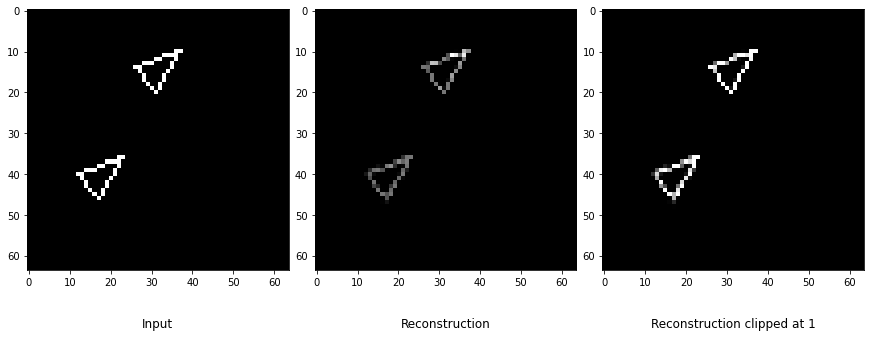

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 



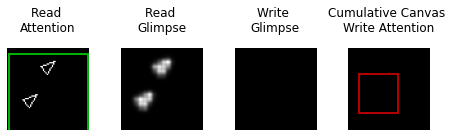

tensor([0.3381, 0.8679, 0.0039, 0.0199])
tensor([1, 0, 3, 2])


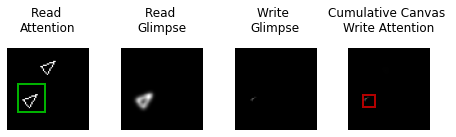

tensor([0.3858, 0.7581, 0.0134, 0.0231])
tensor([1, 0, 3, 2])


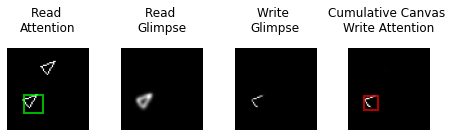

tensor([0.5064, 0.5726, 0.0124, 0.0192])
tensor([1, 0, 3, 2])


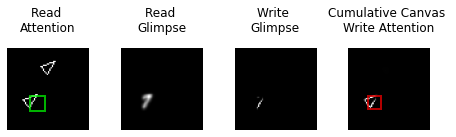

tensor([0.5647, 0.0424, 0.1068, 0.0327])
tensor([0, 2, 1, 3])


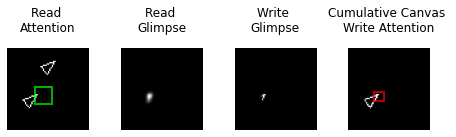

tensor([0.7468, 0.5514, 0.0247, 0.0871])
tensor([0, 1, 3, 2])


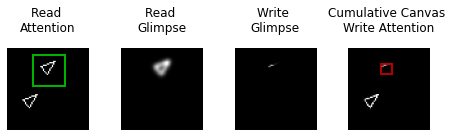

tensor([0.4775, 0.7510, 0.6044, 0.0071])
tensor([1, 2, 0, 3])


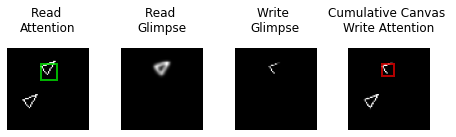

tensor([0.4191, 0.4410, 0.9109, 0.0022])
tensor([2, 1, 0, 3])


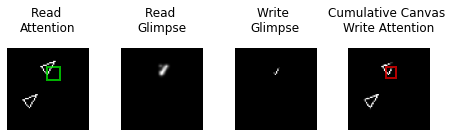

tensor([0.3990, 0.0274, 0.9803, 0.0020])
tensor([2, 0, 1, 3])


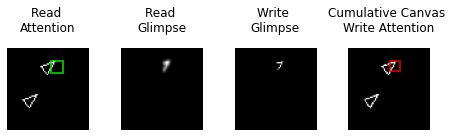

tensor([0.4371, 0.1456, 0.9916, 0.0046])
tensor([2, 0, 1, 3])


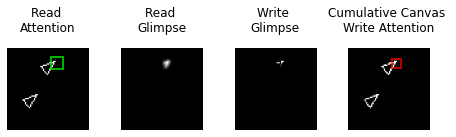

tensor([0.5349, 0.3927, 0.9924, 0.0032])
tensor([2, 0, 1, 3])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([4.8093, 4.5502, 4.6408, 0.2011], device='cuda:0')
tensor([0, 2, 1, 3], device='cuda:0')

****************************************************************************************************
trial 1

ground truth
tensor([1, 1, 1, 0])
tensor([0, 1, 2])
model prediction
tensor([1.0000, 0.9955, 0.9685, 0.1237])
tensor([1.0000, 0.9955, 0.9685, 0.1237])
tensor([0, 1, 2, 3])
partial score, 1.0, exact score, 1.0


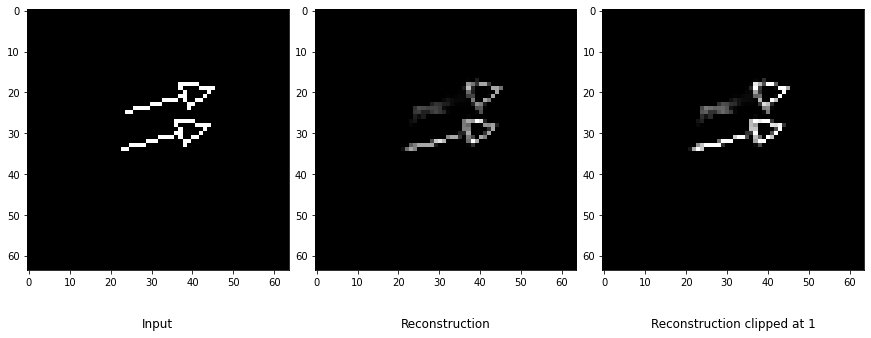

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 



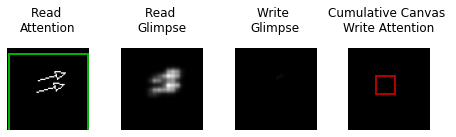

tensor([0.7273, 0.9216, 0.0133, 0.0123])
tensor([1, 0, 2, 3])


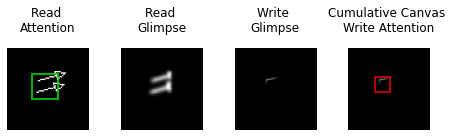

tensor([0.3122, 0.5422, 0.0060, 0.0183])
tensor([1, 0, 3, 2])


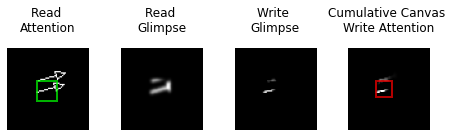

tensor([0.5473, 0.5083, 0.0426, 0.2286])
tensor([0, 1, 3, 2])


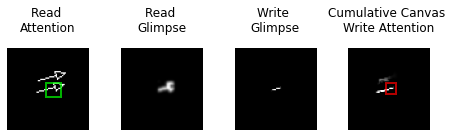

tensor([0.5001, 0.3886, 0.2053, 0.0685])
tensor([0, 1, 2, 3])


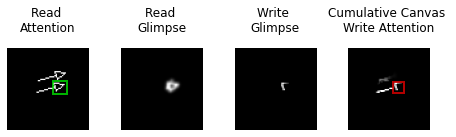

tensor([0.2600, 0.5200, 0.1261, 0.0774])
tensor([1, 0, 2, 3])


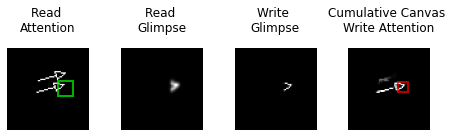

tensor([0.6234, 0.3930, 0.5482, 0.1507])
tensor([0, 2, 1, 3])


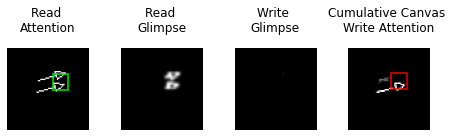

tensor([0.2680, 0.3837, 0.8721, 0.0036])
tensor([2, 1, 0, 3])


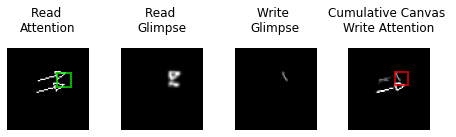

tensor([0.3411, 0.2869, 0.9352, 0.0066])
tensor([2, 0, 1, 3])


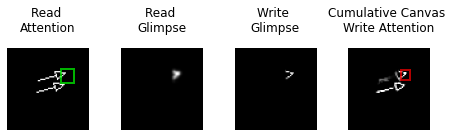

tensor([0.6411, 0.3693, 0.9665, 0.0090])
tensor([2, 0, 1, 3])


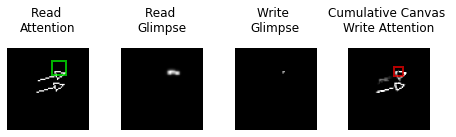

tensor([0.5942, 0.4793, 0.9479, 0.0206])
tensor([2, 0, 1, 3])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([4.8145, 4.7928, 4.6631, 0.5956], device='cuda:0')
tensor([0, 1, 2, 3], device='cuda:0')

****************************************************************************************************
trial 2

ground truth
tensor([1, 1, 1, 0])
tensor([0, 1, 2])
model prediction
tensor([1.0000, 0.9477, 0.9810, 0.1354])
tensor([1.0000, 0.9477, 0.9810, 0.1354])
tensor([0, 1, 2, 3])
partial score, 1.0, exact score, 1.0


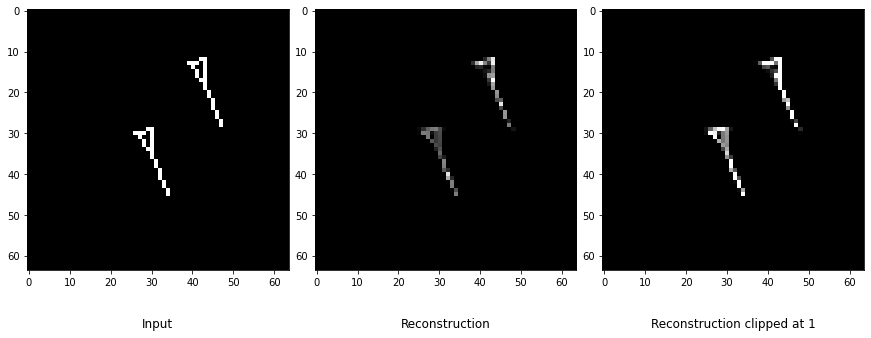

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 



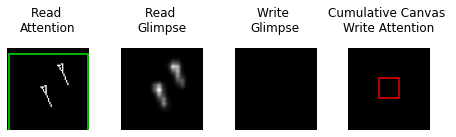

tensor([0.6598, 0.9052, 0.0184, 0.0149])
tensor([1, 0, 2, 3])


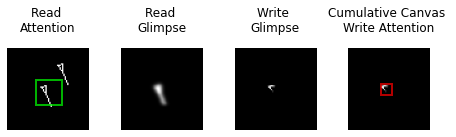

tensor([0.3744, 0.6341, 0.0145, 0.0310])
tensor([1, 0, 3, 2])


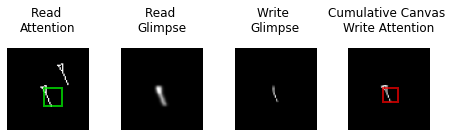

tensor([0.4660, 0.6973, 0.0494, 0.0965])
tensor([1, 0, 3, 2])


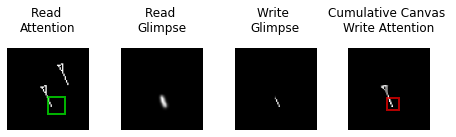

tensor([0.7536, 0.3019, 0.1385, 0.3632])
tensor([0, 3, 1, 2])


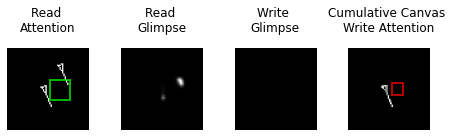

tensor([0.4661, 0.4601, 0.1813, 0.1635])
tensor([0, 1, 2, 3])


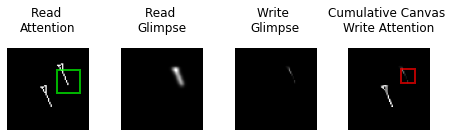

tensor([0.5260, 0.4594, 0.8354, 0.0109])
tensor([2, 0, 1, 3])


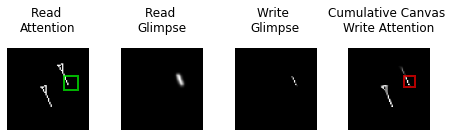

tensor([0.6249, 0.3541, 0.9464, 0.0115])
tensor([2, 0, 1, 3])


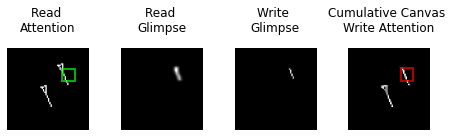

tensor([0.5010, 0.3079, 0.9725, 0.0035])
tensor([2, 0, 1, 3])


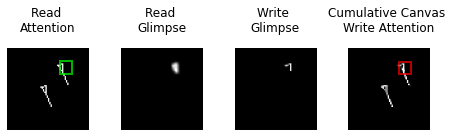

tensor([0.4329, 0.3373, 0.9816, 0.0048])
tensor([2, 0, 1, 3])


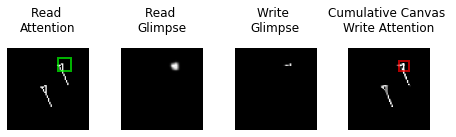

tensor([0.4130, 0.4874, 0.9808, 0.0069])
tensor([2, 1, 0, 3])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([5.2177, 4.9448, 5.1188, 0.7067], device='cuda:0')
tensor([0, 2, 1, 3], device='cuda:0')

****************************************************************************************************
trial 3

ground truth
tensor([1, 1, 1, 0])
tensor([0, 1, 2])
model prediction
tensor([1.0000, 0.9413, 0.5574, 0.6440])
tensor([1.0000, 0.9413, 0.5574, 0.6440])
tensor([0, 1, 2, 3])
partial score, 0.0, exact score, 0.0


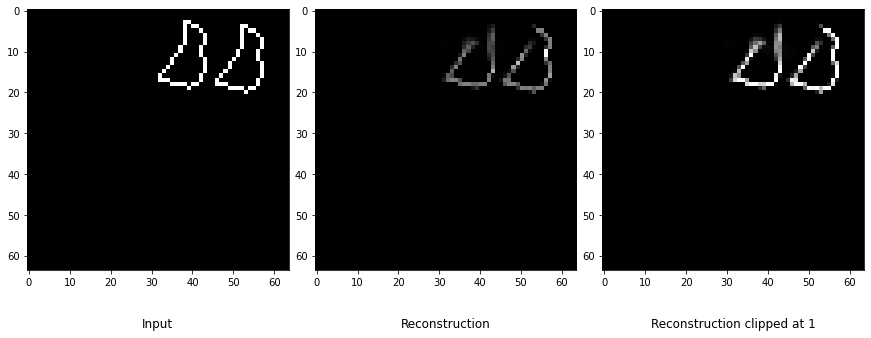

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 



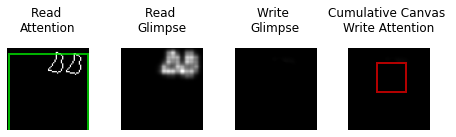

tensor([0.8974, 0.9636, 0.3631, 0.1533])
tensor([1, 0, 2, 3])


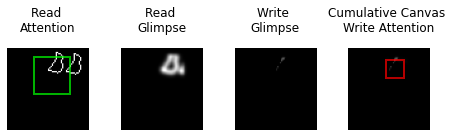

tensor([0.7061, 0.8442, 0.0347, 0.0266])
tensor([1, 0, 2, 3])


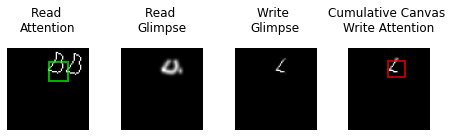

tensor([0.5550, 0.6059, 0.0018, 0.0232])
tensor([1, 0, 3, 2])


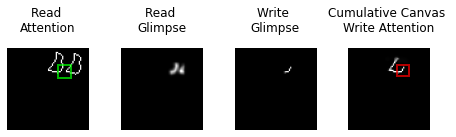

tensor([0.6004, 0.2497, 0.0311, 0.1767])
tensor([0, 1, 3, 2])


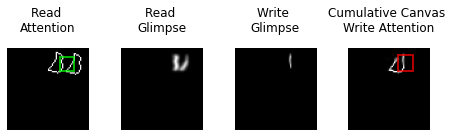

tensor([0.3178, 0.5300, 0.0186, 0.3229])
tensor([1, 3, 0, 2])


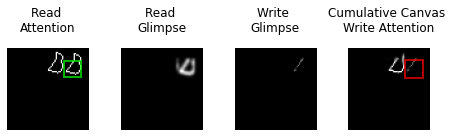

tensor([0.4060, 0.7019, 0.4676, 0.0280])
tensor([1, 2, 0, 3])


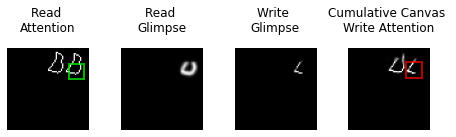

tensor([0.4231, 0.4473, 0.8825, 0.0031])
tensor([2, 1, 0, 3])


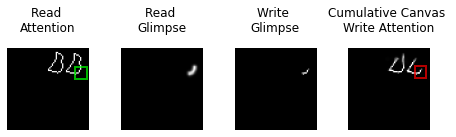

tensor([0.3685, 0.0809, 0.8302, 0.9088])
tensor([3, 2, 0, 1])


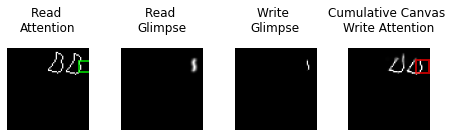

tensor([0.4089, 0.1964, 0.2683, 0.8915])
tensor([3, 0, 2, 1])


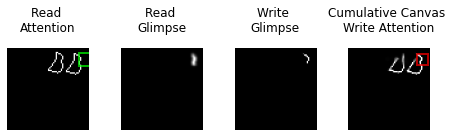

tensor([0.5677, 0.3228, 0.0288, 0.8477])
tensor([3, 0, 1, 2])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([5.2511, 4.9426, 2.9267, 3.3817], device='cuda:0')
tensor([0, 1, 3, 2], device='cuda:0')

****************************************************************************************************
trial 4

ground truth
tensor([1, 1, 1, 0])
tensor([0, 1, 2])
model prediction
tensor([1.0000, 0.9159, 0.8651, 0.1325])
tensor([1.0000, 0.9159, 0.8651, 0.1325])
tensor([0, 1, 2, 3])
partial score, 1.0, exact score, 1.0


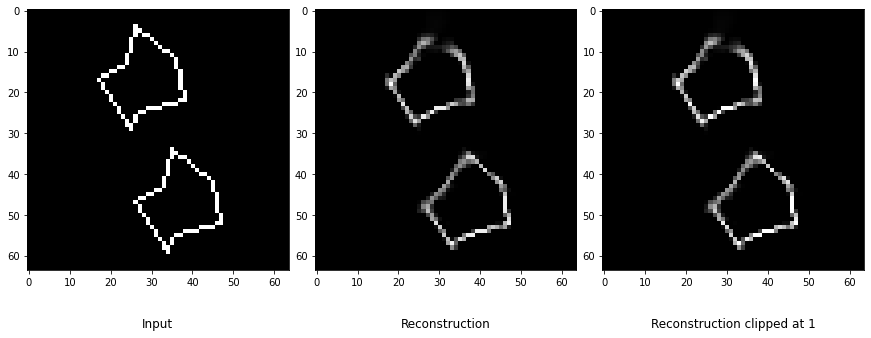

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 



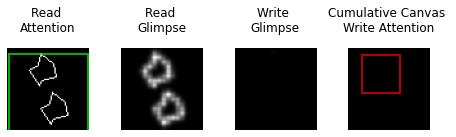

tensor([0.6797, 0.8901, 0.0456, 0.0083])
tensor([1, 0, 2, 3])


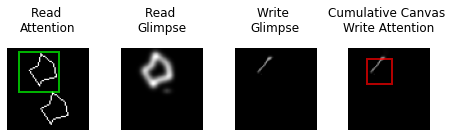

tensor([0.5530, 0.8289, 0.0323, 0.1049])
tensor([1, 0, 3, 2])


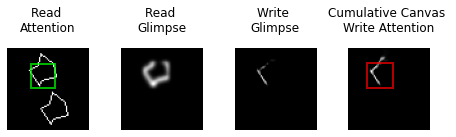

tensor([0.5677, 0.6544, 0.0035, 0.0854])
tensor([1, 0, 3, 2])


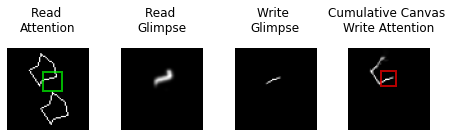

tensor([0.6315, 0.2576, 0.0415, 0.1043])
tensor([0, 1, 3, 2])


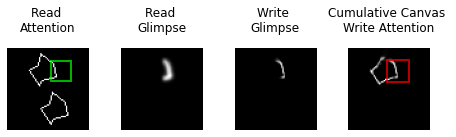

tensor([0.6261, 0.7937, 0.1213, 0.4118])
tensor([1, 0, 3, 2])


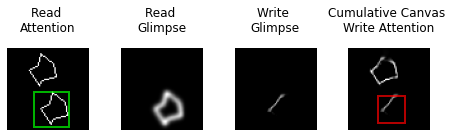

tensor([0.4813, 0.7078, 0.7314, 0.0116])
tensor([2, 1, 0, 3])


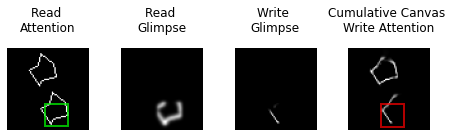

tensor([0.5369, 0.4164, 0.9327, 0.0020])
tensor([2, 0, 1, 3])


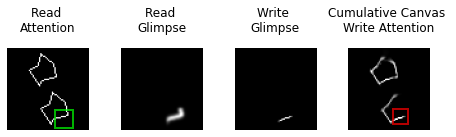

tensor([0.5787, 0.0776, 0.9876, 0.0064])
tensor([2, 0, 1, 3])


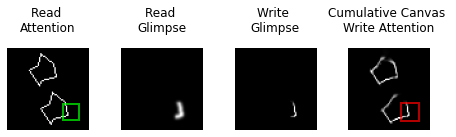

tensor([0.4713, 0.0968, 0.9931, 0.0076])
tensor([2, 0, 1, 3])


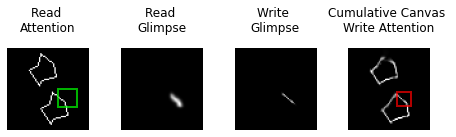

tensor([0.5179, 0.4459, 0.9936, 0.0057])
tensor([2, 0, 1, 3])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([5.6439, 5.1693, 4.8825, 0.7481], device='cuda:0')
tensor([0, 1, 2, 3], device='cuda:0')

****************************************************************************************************
trial 5

ground truth
tensor([1, 1, 1, 0])
tensor([0, 1, 2])
model prediction
tensor([1.0000, 0.8617, 0.8993, 0.0912])
tensor([1.0000, 0.8617, 0.8993, 0.0912])
tensor([0, 1, 2, 3])
partial score, 1.0, exact score, 1.0


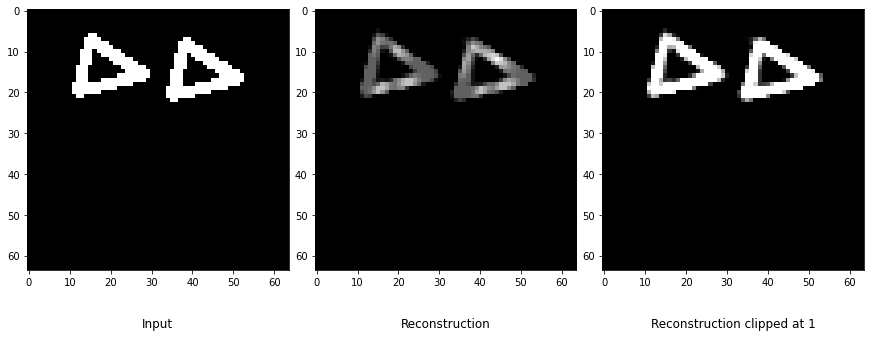

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 



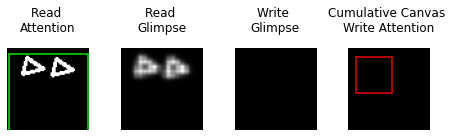

tensor([0.9368, 0.9707, 0.0470, 0.2368])
tensor([1, 0, 3, 2])


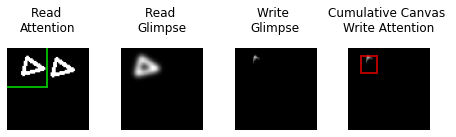

tensor([0.4444, 0.6614, 0.0037, 0.0064])
tensor([1, 0, 3, 2])


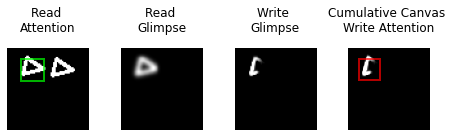

tensor([0.5435, 0.4263, 0.0059, 0.0275])
tensor([0, 1, 3, 2])


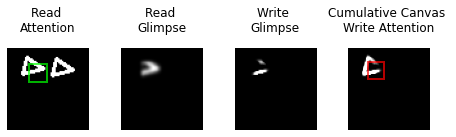

tensor([0.4737, 0.1710, 0.0052, 0.0070])
tensor([0, 1, 3, 2])


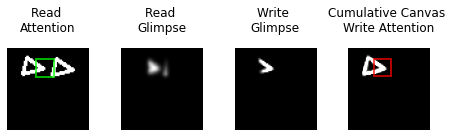

tensor([0.4527, 0.3627, 0.0123, 0.1278])
tensor([0, 1, 3, 2])


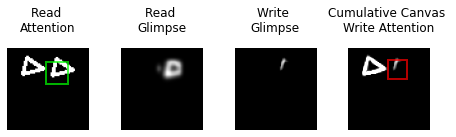

tensor([0.3653, 0.6433, 0.4577, 0.0166])
tensor([1, 2, 0, 3])


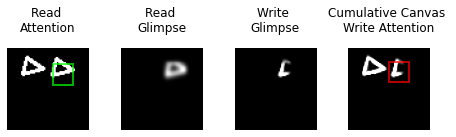

tensor([0.4450, 0.3634, 0.9070, 0.0071])
tensor([2, 0, 1, 3])


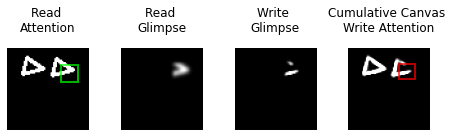

tensor([0.4497, 0.1127, 0.9655, 0.0027])
tensor([2, 0, 1, 3])


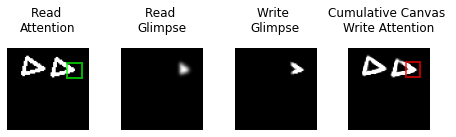

tensor([0.4567, 0.1317, 0.9844, 0.0057])
tensor([2, 0, 1, 3])


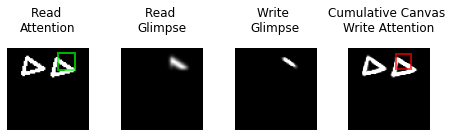

tensor([0.2954, 0.3473, 0.9848, 0.0057])
tensor([2, 1, 0, 3])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([4.8632, 4.1906, 4.3736, 0.4433], device='cuda:0')
tensor([0, 2, 1, 3], device='cuda:0')

****************************************************************************************************
trial 6

ground truth
tensor([1, 1, 1, 0])
tensor([0, 1, 2])
model prediction
tensor([0.9000, 0.9381, 1.0000, 0.0380])
tensor([0.9000, 0.9381, 1.0000, 0.0380])
tensor([0, 1, 2, 3])
partial score, 1.0, exact score, 1.0


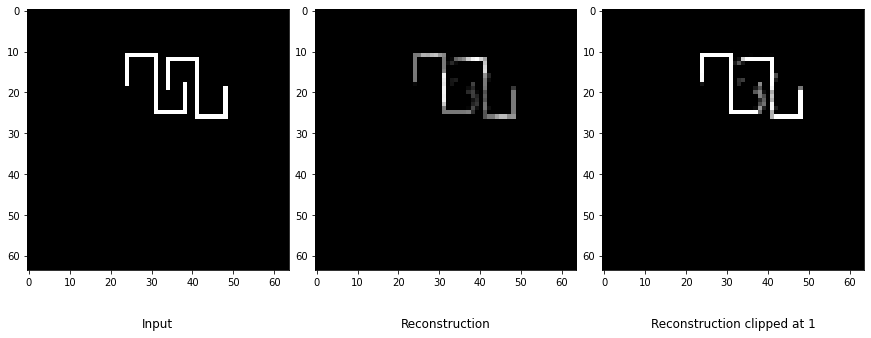

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 



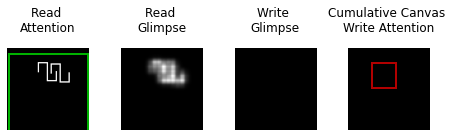

tensor([0.8314, 0.9292, 0.0225, 0.0745])
tensor([1, 0, 3, 2])


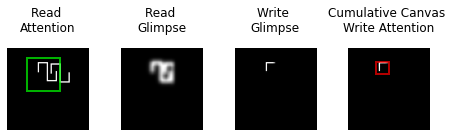

tensor([0.5934, 0.7599, 0.0181, 0.0120])
tensor([1, 0, 2, 3])


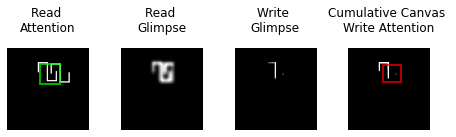

tensor([0.4616, 0.7065, 0.2422, 0.0353])
tensor([1, 0, 2, 3])


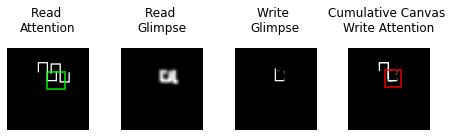

tensor([0.4687, 0.3176, 0.1825, 0.0117])
tensor([0, 1, 2, 3])


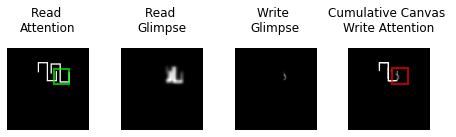

tensor([0.2731, 0.3721, 0.5328, 0.0465])
tensor([2, 1, 0, 3])


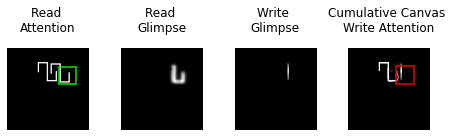

tensor([0.5112, 0.6170, 0.8277, 0.0114])
tensor([2, 1, 0, 3])


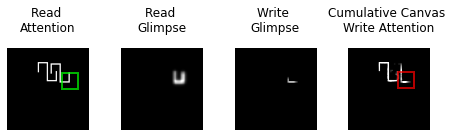

tensor([0.4143, 0.3287, 0.9787, 0.0032])
tensor([2, 0, 1, 3])


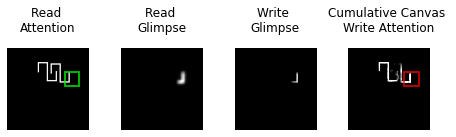

tensor([0.6075, 0.3210, 0.9904, 0.0131])
tensor([2, 0, 1, 3])


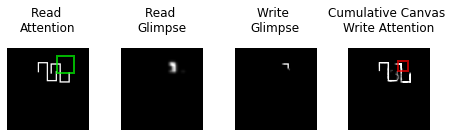

tensor([0.5817, 0.5013, 0.9917, 0.0048])
tensor([2, 0, 1, 3])


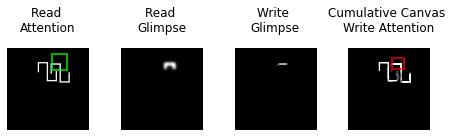

tensor([0.4578, 0.5677, 0.9917, 0.0072])
tensor([2, 1, 0, 3])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([5.2007, 5.4209, 5.7783, 0.2198], device='cuda:0')
tensor([2, 1, 0, 3], device='cuda:0')

****************************************************************************************************
trial 7

ground truth
tensor([1, 1, 0, 1])
tensor([0, 1, 3])
model prediction
tensor([1.0000, 0.9657, 0.0820, 0.9464])
tensor([1.0000, 0.9657, 0.0820, 0.9464])
tensor([0, 1, 2, 3])
partial score, 1.0, exact score, 1.0


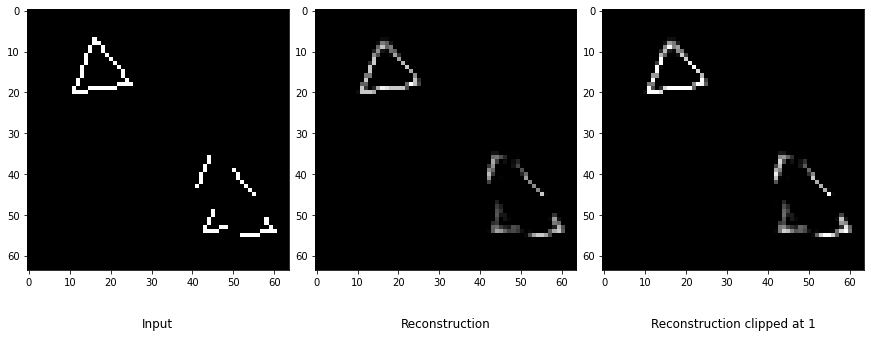

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 



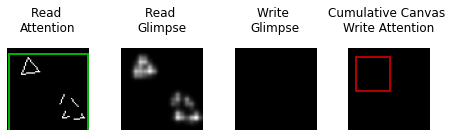

tensor([0.8884, 0.9691, 0.0795, 0.1330])
tensor([1, 0, 3, 2])


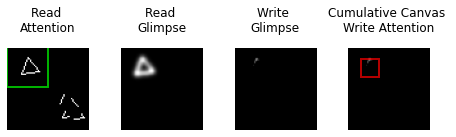

tensor([0.3737, 0.7631, 0.0152, 0.0143])
tensor([1, 0, 2, 3])


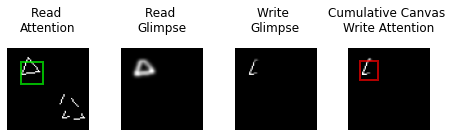

tensor([0.4894, 0.5918, 0.0012, 0.0039])
tensor([1, 0, 3, 2])


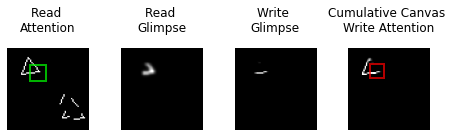

tensor([0.4997, 0.0514, 0.1343, 0.1001])
tensor([0, 2, 3, 1])


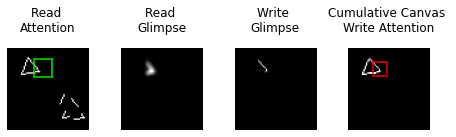

tensor([0.7509, 0.8685, 0.1890, 0.2543])
tensor([1, 0, 3, 2])


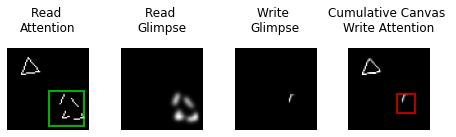

tensor([0.3399, 0.6025, 0.0048, 0.7349])
tensor([3, 1, 0, 2])


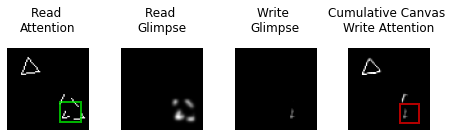

tensor([0.5187, 0.6245, 0.0069, 0.9554])
tensor([3, 1, 0, 2])


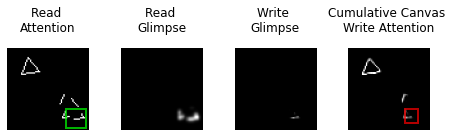

tensor([0.5007, 0.4069, 0.0042, 0.9693])
tensor([3, 0, 1, 2])


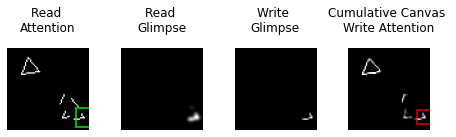

tensor([0.4951, 0.2046, 0.0024, 0.9875])
tensor([3, 0, 1, 2])


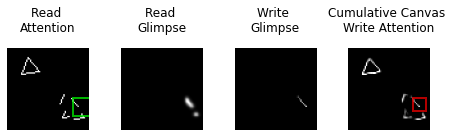

tensor([0.5708, 0.1587, 0.0079, 0.9838])
tensor([3, 0, 1, 2])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([5.4274, 5.2410, 0.4453, 5.1365], device='cuda:0')
tensor([0, 1, 3, 2], device='cuda:0')


In [14]:
import matplotlib.gridspec as gridspec

num_trials = 8

save_plot = 1
create_gif = 1
 # folder to save figs/gifs  
    
fig_folder = './results/svrt_task1/run1/' 

if not os.path.isdir(fig_folder):
    os.makedirs(fig_folder)

if args.use_read_attn == False:
    args.read_size = args.image_dims[1]

if args.use_write_attn == False:
    args.write_size = args.image_dims[1]

y_pred_nars = y_pred #.narrow(1,0,args.num_classes) 
y_pred_hots, _ , paccs , _, eaccs = cal_accs(y_pred_nars, y.to(args.device), readout_logits, args)

for i in range(num_trials): #len(y)):
    


    y_true = y[i].cpu()

    if torch.max(y_true) == 1: #len(torch.nonzero(y[i])[0]) > 1:
        y_os = torch.squeeze(torch.nonzero(torch.squeeze(y_true)))
    else:
        y_os = torch.cat( (torch.nonzero(torch.squeeze(y_true))[0], torch.nonzero(torch.squeeze(y_true))[0]))

    y_pred_hot = y_pred_hots[i].cpu()
    y_pred_nar = y_pred_nars[i].cpu()
    if torch.max(y_pred_hot) == 1: #len(torch.nonzero(y[i])[0]) > 1:
        y_pred_os = torch.squeeze(torch.nonzero(torch.squeeze(y_pred_hot)))
    else:
        y_pred_os = torch.cat( (torch.nonzero(torch.squeeze(y_pred_hot))[0], torch.nonzero(torch.squeeze(y_pred_hot))[0]))

    correct_partial = paccs[i].cpu()
    correct_exact = eaccs[i].cpu()

    # if only incorrect trials 
#     if correct_partial == 1:
#         continue 
        
    print('\n' + '*'*100)
    print('trial ' + str(i))
        
    print('\nground truth')
    print(y_true)
    print(y_os)
    
    print('model prediction')
    print(y_pred_nar)
    print(y_pred_hot)
    print(y_pred_os)
        
    print(f'partial score, {correct_partial}, exact score, {correct_exact}')
    
        
    g_h = 1
    g_w = 3
    fig = plt.figure(figsize=(15,6))
    gs1 = gridspec.GridSpec(g_h, g_w)
    gs1.update(wspace=0.1, hspace=0.1)  # set the spacing between axes.

    ax = plt.subplot(gs1[0,0])
    ax.imshow(torch.squeeze(x[i].movedim(0,-1)), cmap='gray')
    ax.text(0.5,-0.22,  "Input", size=12, ha="center", transform=ax.transAxes)

    ax = plt.subplot(gs1[0,1])
    ax.imshow(np.squeeze(torch.sum(c_each[i], dim=0).movedim(0,-1).cpu().numpy()), cmap='gray')
    ax.text(0.5,-0.22,  "Reconstruction", size=12, ha="center", transform=ax.transAxes)
    
    ax = plt.subplot(gs1[0,2])
    ax.imshow(np.squeeze(torch.sum(c_each[i], dim=0).movedim(0,-1).cpu().numpy()), vmin=0, vmax=1, cmap='gray')
    ax.text(0.5,-0.22,  "Reconstruction clipped at 1", size=12, ha="center", transform=ax.transAxes)
    
    plt.show()
    

    #--------------------------------------
    # plotting read and  write operatoins 
    
    print('_ ' * 40 + '\n')
    class_l = torch.zeros((args.time_steps, args.num_classes))
    
    for j in range(args.time_steps):
        
        class_l[j,:] = objcaps_len_step[j][i]
        class_sorted, indices = torch.sort(class_l[j,:], dim=0, descending=True)
        
        g_h = 1
        g_w = 5
        fig = plt.figure(figsize=(10,1.5))
        gs1 = gridspec.GridSpec(g_h, g_w)
        gs1.update(wspace=0.1, hspace=0.1)

        class_l = torch.zeros((args.time_steps, args.num_classes)) #
    
        ax = plt.subplot(gs1[0,0])
        
#         if args.task == 'MultiMNIST_tracking':
#             print(x[i].shape)
#             x_t = x[i].narrow(0,j,1)
            
#         else:
        x_t = x[i]
    
    
    
    ##### individual read attention 
#         fig_size = 2
#         line_w = 4
#         fig= plt.figure(figsize=(fig_size,fig_size))
#         gs1 = gridspec.GridSpec(1, 1)
#         ax = plt.subplot(gs1[0,0])
#         ax.imshow(torch.squeeze(x[i].movedim(0,-1)), vmin=0, vmax=1, cmap='gray')
#         ax.axis('off')


#         if args.use_read_attn:
#             mu_x = read_mu_xs[j][i]
#             mu_y = read_mu_ys[j][i]

#             r_x = mu_x[0]
#             r_y = mu_y[0]
#             r_w = mu_y[-1] - mu_y[0]
#             r_h = mu_x[-1] - mu_x[0]

#             ax.add_patch(Rectangle((r_x, r_y), r_w, r_h, facecolor='none', edgecolor='lime', linewidth=2, alpha=0.7))


#         plt.show()    
#         fig_name = fig_folder + str(i) + '/' + 'read_att_t' + str(i) + '_s' + str(j) + '_caps' + str(indices[0]) \
#                                                 + '_' + str(class_sorted[0]) + '.png'
#         fig.savefig(fig_name)
                
#         continue



        ax.imshow(torch.squeeze(x_t.movedim(0,-1)), vmin=0, vmax=1, cmap='gray')
        ax.axis('off')
        
        ax.text(0.5,1.2,  "Read \nAttention", \
        size=12, ha="center", transform=ax.transAxes)
        
        #if args.use_glimpse_attn:
        if args.use_read_attn:
            mu_x = read_mu_xs[j][i]
            mu_y = read_mu_ys[j][i]

            r_x = mu_x[0]
            r_y = mu_y[0]
            r_w = mu_y[-1] - mu_y[0]
            r_h = mu_x[-1] - mu_x[0]

            ax.add_patch(Rectangle((r_x, r_y), r_w, r_h, facecolor='none', edgecolor='lime', linewidth=2, alpha=0.7))
            #-------------------------------------

#         if args.use_soft_attn:
#             p = j*step_num 
#             soft_map = att_param[p][7][i].cpu().numpy()
            
#             soft_map = np.reshape(soft_map, (8, 8))
#             plt.imshow(soft_map)
#             plt.show()
#             print(len(soft_map))
#             print(soft_map[0].shape)
#             break

            
        ax = plt.subplot(gs1[0,1])
        ax.imshow(read_x_step[i][j].movedim(0,-1).cpu(), cmap='gray')
        ax.axis('off')
        #if j==0:
        ax.text(0.5,1.2,  "Read \nGlimpse", \
        size=12, ha="center", transform=ax.transAxes)
            
        
        #---------------------------------------
        if args.recon_model:
            #im = np.reshape(torch.squeeze(c_cumu_step[j][i]).cpu().numpy(), (args.image_dims[1],args.image_dims[2]))
            im = np.reshape(torch.squeeze(c_cumu_step[j][i]).cpu().numpy(), \
                                (args.image_dims[0], args.image_dims[1],args.image_dims[2])).transpose(1,2,0)

            ax = plt.subplot(gs1[0,3])
            ax.imshow(im, vmin=0, vmax=1 , cmap='gray')  # max(np.max(im),1)
            ax.axis('off')

            #if j==0:
            ax.text(0.5,1.2,  "Cumulative Canvas \nWrite Attention", \
            size=12, ha="center", transform=ax.transAxes)
            
            
        
        
#             fig_size = 2
#             line_w = 4
#             fig= plt.figure(figsize=(fig_size,fig_size))
#             gs1 = gridspec.GridSpec(1, 1)
#             ax = plt.subplot(gs1[0,0])
#             ax.imshow(im, vmin=0, vmax=1, cmap='gray')
#             ax.axis('off')


#             if args.use_write_attn:
#                 mu_x = write_mu_xs[j][i]
#                 mu_y = write_mu_ys[j][i]

#                 w_x = mu_x[0]
#                 w_y = mu_y[0]
#                 w_w = mu_y[-1] - mu_y[0]
#                 w_h = mu_x[-1] - mu_x[0]

#                 ax.add_patch(Rectangle((w_x, w_y), w_w, w_h, facecolor='none', edgecolor='red', linewidth=2, alpha=0.7))


#             plt.show()    
#             save_folder = fig_folder + str(i) + '/'
#             if not os.path.isdir(save_folder):
#                 os.makedirs(save_folder)
                
#             fig_name = save_folder + 'write_att_t' + str(i) + '_s' + str(j) + '_caps' + str(indices[0]) \
#                                                     + '_' + str(class_sorted[0]) + '.png'
#             fig.savefig(fig_name)

#             continue
        
        
        
        
            
            if args.use_write_attn:
                mu_x = write_mu_xs[j][i]
                mu_y = write_mu_ys[j][i]

                w_x = mu_x[0]
                w_y = mu_y[0]
                w_w = mu_y[-1] - mu_y[0]
                w_h = mu_x[-1] - mu_x[0]

                ax.add_patch(Rectangle((w_x, w_y), w_w, w_h, facecolor='none', edgecolor='red', linewidth=2, alpha=0.7))
                
                c_each = torch.clip(c_each, min=0, max=1)

                ax = plt.subplot(gs1[0,2])
                ax.imshow(c_each[i][j].movedim(0,-1).cpu(), vmin=0, vmax=1, cmap='gray')
                ax.axis('off')
                #if j==0:
                ax.text(0.5,1.2,  "Write \nGlimpse", \
                size=12, ha="center", transform=ax.transAxes)
        
#                 if args.task == 'MultiMNIST_tracking':
#                     x_t = x[i].narrow(0,j+1,1)
#                     ax = plt.subplot(gs1[j,5])
#                     ax.imshow(torch.squeeze(x_t.movedim(0,-1)), vmin=0, vmax=1, cmap='gray')
                        


        if save_plot:
            
            plt.margins(0,0)    
            save_folder = fig_folder + str(i) + '/'
            if not os.path.isdir(save_folder):
                os.makedirs(save_folder)
            fig.savefig( save_folder + 'image{:02d}'.format(j) + '.png', bbox_inches='tight', pad_inches=0.0)

        plt.show()
        
        class_l[j,:] = objcaps_len_step[i][j]
        class_sorted, indices = torch.sort(class_l[j,:], dim=0, descending=True)

        print(class_l[j,:])  # .cpu().numpy()
        print(indices)   # .cpu().numpy()
        #print('_ ' * 40 + '\n')
    
    print('_ ' * 40 + '\n')
    class_l_sum = torch.sum(objcaps_len_step[i],dim=0)
    print(class_l_sum)
    class_sorted_sum, indices_sum = torch.sort(class_l_sum, dim=0, descending=True)
    print(indices_sum)
        
    if save_plot:    
        if create_gif:  

            import imageio
            from PIL import Image
            import glob
            image_list = []
            for filename in glob.glob(save_folder+ '/*.png'): #assuming gif
                im=Image.open(filename)
                image_list.append(np.array(im))


            file_add = (os.path.join(save_folder, 'generated_{}_time_steps_t{}.gif'.format(args.time_steps, args.num_targets)))
            imageio.mimsave(file_add, image_list, duration=0.4)


            #print("The accuracy for this batch is: " + str(test_acc) )

            IP_Image(open(file_add,'rb').read(), width = 600, height = 600)
    
    
    